# basic tests

In [4]:
from PandaStation import MakePandaStation


# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])

# Let's do all of our imports here, too.
import numpy as np
import ipywidgets
import pydot
import pydrake.all
import os
from IPython.display import display, SVG

import pydrake.all

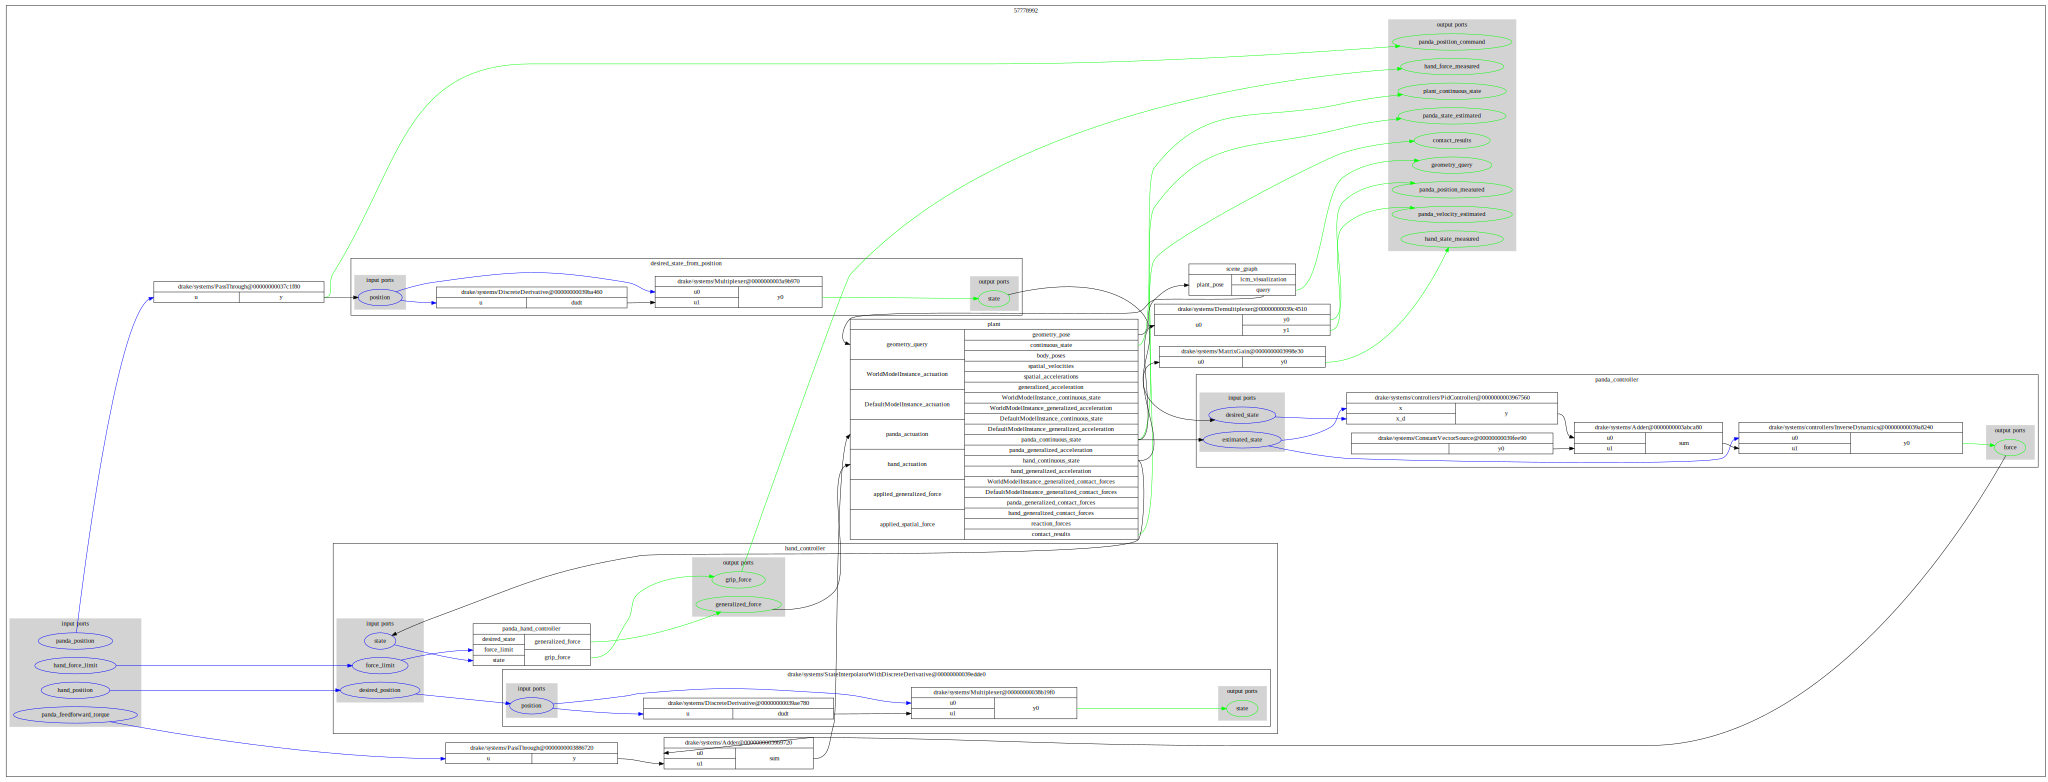

True

In [11]:
diagram = MakePandaStation()

style = "<style>svg{width:100% !important;height:100% !important;</style>"


display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_png("./media/pictures/panda_station.png")

In [12]:
def TestWithMeshcat():
    builder = pydrake.systems.framework.DiagramBuilder()
    station = builder.AddSystem(MakePandaStation())

    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, output_port=station.GetOutputPort("geometry_query"), zmq_url=zmq_url)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    visualizer.load(visualizer.GetMyContextFromRoot(context))
    diagram.Publish(context)

TestWithMeshcat()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
Connected to meshcat-server.


# Testing control

In [16]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(pydrake.systems.framework.LeafSystem):
    def __init__(self, plant):
        pydrake.systems.framework.LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("panda")
        self._G = plant.GetBodyByName("panda_hand").body_frame()
        self._W = plant.world_frame()

        self.DeclareVectorInputPort("panda_position", pydrake.systems.framework.BasicVector(7))
        self.DeclareVectorOutputPort("panda_velocity", pydrake.systems.framework.BasicVector(7), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, pydrake.multibody.tree.JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,0:7] # Ignore gripper terms
        
        V_G_desired = np.array([0,    # rotation about x
                                -.1,  # rotation about y
                                0,    # rotation about z
                                0,    # x
                                -.05, # y
                                -.1]) # z
        v = np.linalg.pinv(J_G).dot(V_G_desired)
        output.SetFromVector(v)

        
def jacobian_controller_example():
    builder = pydrake.systems.framework.DiagramBuilder()

    station = builder.AddSystem(MakePandaStation())

    controller = builder.AddSystem(PseudoInverseController(
        station.get_multibody_plant()))
    integrator = builder.AddSystem(pydrake.systems.primitives.Integrator(7))

    builder.Connect(controller.get_output_port(), 
                    integrator.get_input_port())
    builder.Connect(integrator.get_output_port(),
                    station.GetInputPort("panda_position"))
    builder.Connect(station.GetOutputPort("panda_position_measured"),
                    controller.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("query_object"),
        zmq_url=zmq_url)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
    #station.GetInputPort("panda_feedforward_torque").FixValue(station_context, np.zeros((7,1))) // this will already be 0
    station.GetInputPort("hand_position").FixValue(station_context, [0.1])
    # TODO(russt): Add this missing python binding
    #integrator.set_integral_value(
    #    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
    #        station.GetIiwaPosition(station_context))
    integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01);

    return simulator

simulator = jacobian_controller_example()

AttributeError: 'Diagram_[float]' object has no attribute 'get_multibody_plant'

In [ ]:
simulator.AdvanceTo(5.0)